# Amazon Book Rating Predictor

Online services such as Amazon and Netflix make extensive use of prediction algorithms to give users new product recommendations. While these systems can make reasonable predictions just using simple means for items or users, they can give much more accurate predicitons by taking into account the relationships between items and users. Essentially, finding correlations between similar items and users in order to determine what users will rank an item the highest.

Several algorithms are used to build these rating systems, but what is their relative performance? How much advantage is there in using an autoencoder versus a simple linear model? This project explores the relative performance of five different recommendation algorithms, linear regression, cosine similarity, singular value decomposition, restricted Boltzmann machines, and autoencoders.

## Data

The data used for this project was collected by Julian McAuley as the University of California San Diego, and is available [here](http://jmcauley.ucsd.edu/data/amazon/). This project focuses only on book reviews. I also restrict my analysis to the 5-core data, which is users who have reviewed at least 5 items. This restriction helps avoid some of the more complex issues of dealing with highly sparse matrices.

## Performance Measure

While the ratings take integer values for each individual observation, they can be considered a continuous measure between 1 and 5. Therefore, I use a standard measure of accuracy, root mean squared error.

## Data Preparation

Each algorithm will need the data in a slightly different format. The original format is a single large json file. So I start by reformatting the data in something easier to work with.

I use Dask to quickly read the json file, and convert it into a Pandas dataframe.

In [38]:
# use dask to efficiently read the json file
from dask import bag
from dask.diagnostics import ProgressBar
import pandas as pd
import json

In [41]:
js = bag.read_text('input/reviews_Books_5.json.gz').map(json.loads)
js.take(5)

({'asin': '000100039X',
  'helpful': [0, 0],
  'overall': 5.0,
  'reviewText': 'Spiritually and mentally inspiring! A book that allows you to question your morals and will help you discover who you really are!',
  'reviewTime': '12 16, 2012',
  'reviewerID': 'A10000012B7CGYKOMPQ4L',
  'reviewerName': 'Adam',
  'summary': 'Wonderful!',
  'unixReviewTime': 1355616000},
 {'asin': '000100039X',
  'helpful': [0, 2],
  'overall': 5.0,
  'reviewText': "This is one my must have books. It is a masterpiece of spirituality. I'll be the first to admit, its literary quality isn't much. It is rather simplistically written, but the message behind it is so powerful that you have to read it. It will take you to enlightenment.",
  'reviewTime': '12 11, 2003',
  'reviewerID': 'A2S166WSCFIFP5',
  'reviewerName': 'adead_poet@hotmail.com "adead_poet@hotmail.com"',
  'summary': 'close to god',
  'unixReviewTime': 1071100800},
 {'asin': '000100039X',
  'helpful': [0, 0],
  'overall': 5.0,
  'reviewText': 'Thi

In [8]:
# load json data as a dask bag
js = bag.read_text('input/reviews_Books_5.json.gz').map(json.loads)
# convert each variable of interest into an array to add to a dataframe
asin = js.pluck('asin')
reviewerID = js.pluck('reviewerID')
overall = js.pluck('overall')
# convert to pandas dataframe, this line will take a few minutes
with ProgressBar():
    ratings_df = pd.DataFrame({'asin':asin.compute(), 
                               'reviewerID':reviewerID.compute(), 
                               'overall':overall.compute()})

[########################################] | 100% Completed |  4min 17.1s
[########################################] | 100% Completed |  4min 18.3s
[########################################] | 100% Completed |  3min 46.9s


In [42]:
# take a look at the data
ratings_df.head()

NameError: name 'ratings_df' is not defined

Because I'll need to make these ratings into a sparse matrix, it's easiest to convert the data into all numeric values. I then save the dataframe to a csv file so that when I need to load the data in again later, I don't have to read the json files.

In [10]:
# Encode the asin and reviewerID for use with sparse matrices later

from sklearn.preprocessing import LabelEncoder

item_le = LabelEncoder()
item_le.fit(ratings_df['asin'])
reviewer_le = LabelEncoder()
reviewer_le.fit(ratings_df['reviewerID'])
ratings_num_df = pd.DataFrame({'asin':item_le.transform(ratings_df['asin']),
                               'reviewerID':reviewer_le.transform(ratings_df['reviewerID']),
                               'rating':ratings_df['overall']})

In [43]:
# save this file to make loading faster in the future
#ratings_num_df.to_csv('input/ratings_long.csv', index = False)

ratings_num_df = pd.read_csv('input/ratings_long.csv')
ratings_num_df.head()

,asin,rating,reviewerID
0,0,5.0,551
1,0,5.0,284567
2,0,5.0,52489
3,0,5.0,101774
4,0,5.0,310083


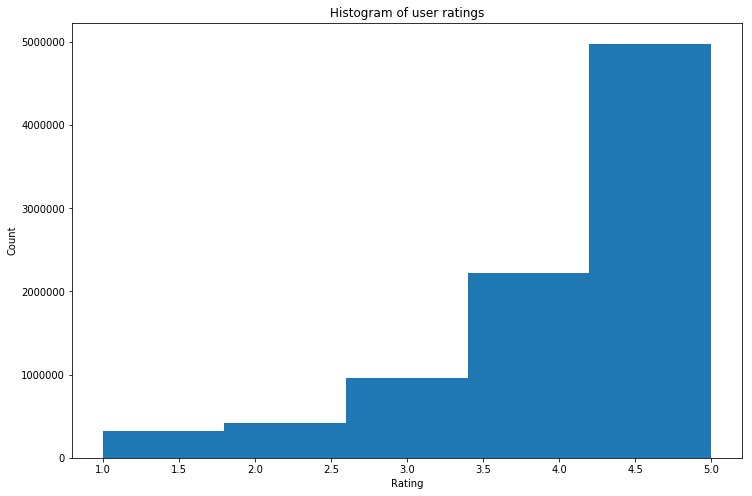

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.hist(ratings_num_df['rating'], bins = 5)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of user ratings')
plt.show()

In [63]:
ratings_num_df['rating'].value_counts()/len(ratings_num_df['rating'])

5.0    0.559765
4.0    0.249841
3.0    0.107348
2.0    0.046652
1.0    0.036394
Name: rating, dtype: float64

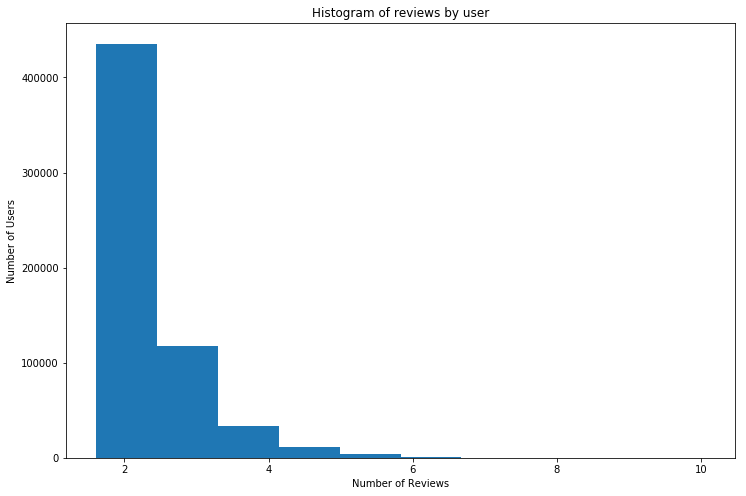

In [70]:
# count of reviews by users
ratings_num_df['count'] = 1
user_counts = ratings_num_df.groupby('reviewerID').agg({'count':np.sum}).reset_index()
user_counts['count'] = np.log(user_counts['count'])
plt.figure(figsize = (12,8))
plt.hist(user_counts['count'])
plt.xlabel('Number of Reviews (log)')
plt.ylabel('Number of Users')
plt.title('Histogram of reviews by user')
plt.show()


In [73]:
#user_counts = ratings_num_df.groupby('reviewerID').agg({'count':np.sum}).reset_index()
print(user_counts['count'].mean())
print(user_counts['count'].median())
print(user_counts['count'].mode())

14.739958056415116
8.0
0    5
dtype: int64


## Training vs Test data

In order to get an idea of the performance of each method, I split the data into training and test sets. I use the same random seed in order to make sure each algorithm gets the same training and test data.

## Baseline

Before exploring each algorithm, we need a baseline of comparison. A simple baseline model would be to take the mean. But which mean? We could take the overall mean of all items, and predict this single value for everything. We could also take the mean of each individual item, and guess this when the item appears in the test data, or we could do the same but by users. An important note in these last two techniques is there is a chance some users or items will appear in the test data, but not the training data. In this case the overall mean will be used.

In [35]:
# get training and test data
from sklearn.model_selection import train_test_split
import numpy as np
train_df, test_df = train_test_split(ratings_num_df, test_size = .1, random_state = 42)

# get overall mean in training data
overall_mean = train_df['rating'].mean()

# get item based means in training data
item_means = train_df.groupby('asin').agg({'rating': np.mean}).reset_index()
item_means.columns = ['asin', 'item_mean']

# get user based means in training data
user_means = train_df.groupby('reviewerID').agg({'rating': np.mean}).reset_index()
user_means.columns = ['reviewerID', 'user_mean']

test_means_df = test_df.copy()
test_means_df['overall_mean'] = overall_mean
test_means_df = test_means_df.merge(item_means, on = 'asin', how = 'left')
test_means_df = test_means_df.merge(user_means, on = 'reviewerID', how = 'left')
test_means_df = test_means_df.fillna(overall_mean)

In [13]:
# user RMSE to see performance of each
from sklearn.metrics import mean_squared_error as mse

print("Overall mean RMSE: {}".format(np.sqrt(mse(test_means_df['rating'], test_means_df['overall_mean']))))
print("Item mean RMSE: {}".format(np.sqrt(mse(test_means_df['rating'], test_means_df['item_mean']))))
print("User mean RMSE: {}".format(np.sqrt(mse(test_means_df['rating'], test_means_df['user_mean']))))

Overall mean RMSE: 1.0578301022101093
Item mean RMSE: 1.0100346145012609
User mean RMSE: 0.9659171214770267


Using item or user mean does slightly better than guessing the overall mean, but not by a huge amount. So the goal is to find a method that can do significantly better than about .96 RMSE.

## Linear Regression

I'll start with a relatively simple method of using linear regression. The idea is that the user and item means are likely correlated, so taking both into account will generate some improvement in prediction. So in the training data I'll regress the ratings on user and item mean, and use this model to generate predictions in the test data.

In [14]:
# import statsmodel
import statsmodels.api as sm
# create new training dataframe with user and item means
train_ols_df = train_df.copy()
train_ols_df = train_ols_df.merge(item_means, on = 'asin', how = 'left')
train_ols_df = train_ols_df.merge(user_means, on = 'reviewerID', how = 'left')
train_ols_df = train_ols_df[['rating', 'item_mean', 'user_mean']]

# build ols model
ols_model = sm.OLS(train_ols_df['rating'], train_ols_df[['item_mean', 'user_mean']]).fit()
ols_model.summary()

/home/ben/anaconda2/envs/tensorflow/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 9.996e+07
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:06:48   Log-Likelihood:            -1.0151e+07
No. Observations:             8008236   AIC:                         2.030e+07
Df Residuals:                 8008234   BIC:                         2.030e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
item_mean      0.3224      0.000    670.336      0.000       0.321       0.323
user_mean      0.6824      0.000   1424.725      0.000       0.681       0.683
==============================================================================
Omnibus:                  1630131.567   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3166161.695
Skew:                          -1.245   Prob(JB):                         0.00
Kurtosis:                       4.814   Cond. No.                         13.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# now predict on the test data

test_ols_df = test_df.copy()
test_ols_df = test_ols_df.merge(item_means, on = 'asin', how = 'left')
test_ols_df = test_ols_df.merge(user_means, on = 'reviewerID', how = 'left')
test_ols_df = test_ols_df.fillna(overall_mean)
test_ols_df['prediction'] = ols_model.predict(test_ols_df[['item_mean', 'user_mean']])
test_ols_df['prediction'] = [5 if i>5 else 1 if i<1 else i for i in test_ols_df['prediction']]

print("OLS RMSE: {}".format(np.sqrt(mse(test_ols_df['rating'], test_ols_df['prediction']))))

OLS RMSE: 0.9272107100780972


That's an improvement beyond the baseline. So it appears there is some correlation in item and user mean that OLS accounts for. To go a step futher, I add an interaction to the OLS model.

In [16]:
train_ols_df['item_user_int'] = train_ols_df['item_mean'] * train_ols_df['user_mean'] 

# build ols model
ols_model = sm.OLS(train_ols_df['rating'], train_ols_df[['item_mean', 'user_mean', 
                                                         'item_user_int']]).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 7.067e+07
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:06:52   Log-Likelihood:            -9.9245e+06
No. Observations:             8008236   AIC:                         1.985e+07
Df Residuals:                 8008233   BIC:                         1.985e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
item_mean         0.1454      0.001    272.040      0.000       0.144       0.146
user_mean         0.3196      0.001    452.158      0.000       0.318       0.321
item_user_int     0.1255      0.000    682.075      0.000       0.125       0.126
==============================================================================
Omnibus:                  1043573.771   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1855918.572
Skew:                          -0.865   Prob(JB):                         0.00
Kurtosis:                       4.603   Cond. No.                         48.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
test_ols_df['item_user_int'] = test_ols_df['item_mean'] * test_ols_df['user_mean'] 
test_ols_df['prediction'] = ols_model.predict(test_ols_df[['item_mean', 'user_mean', 'item_user_int']])
test_ols_df['prediction'] = [5 if i>5 else 1 if i<1 else i for i in test_ols_df['prediction']]

print("OLS with interaction RMSE: {}".format(np.sqrt(mse(test_ols_df['rating'], test_ols_df['prediction']))))

OLS with interaction RMSE: 0.9234251459852182


So that does only slightly better. Adding terms to a regression model will always improve its performance on the training data, but in this case we see improvement on the test data, indicating that the interactions might actually be identifying something. For example, this could mean that users that already give high ratings are more likely to give high ratings when they're reviewing an item that tends to get a high rating.

## Cosine Similarity

Next I try cosine similarity between users. Cosine similarity between two users (k and a) is calculated as

## $S_{u}^{cos}(u_{k},u_{a}) = \frac{u_{k} \cdot u_{a}}{||u_{k}|| ||u_{a}||} = \frac{\Sigma x_{k,m}x_{a,m}}{\sqrt{\Sigma x_{k,m}^{2}x_{a,m}^{2}}}$

Where m is an item. In qualitative terms, this means find two users that have reviewed the same items. For each user, construct a vector of the items both have reviewed, and calculate the angle between those vectors. This gives us some idea of which users have similar tastes. We can then plug these similarities in as an adjustment to the user mean using the formula

## $\hat{x}_{k,m} = \bar{x}_{k} + \frac{\Sigma_{u_{a}} sim_{u}(u_{k},u_{a})(x_{a,m} - \bar{x}_{u_{a}})}{\Sigma_{u_{a}}|sim_{u}(u_{k},u_{a})|}$

Again, in qualitative terms, if we want to estimate the rating for a given user, take that user's mean. Then for each follow user for which we have a similarity and that follow user has reviewed the item of interest, get the difference in the fellow user's rating for that item and the fellow user's overall mean. Multiply by the user similarity. Sum across all users for which these criteria are met, and divide by the magnitude of all similarities in this set of users.

### Computational Difficulty

Cosine similarity presents a particular challenge with this dataset because of its size. There are 603668 users in the data, which means calculating 364,415,054,224 similarity scores. Assuming the values are stored as standard double precision floating point values, this is about 3TB of data, far more than can fit in memory on most machines (the machine I'm using for the analysis has 32GB of RAM). However, the vast majority of these values will be zero, and the vast majority of calculations only need to be performed between a limited number of users. Therefore, the data can be represented in a sparse matrix form of a more reasonable size.



In [14]:
# start by generating a sparse matrix of the training data
from scipy import sparse

arr = np.array(train_df)
shape = tuple([arr.max(axis=0)[2]+1] + [arr.max(axis=0)[0]+1])
train_adj = sparse.csc_matrix((arr[:,1], (arr[:,2], arr[:,0])), shape = shape, dtype = arr.dtype)

# need to user means for the second part of the calcuation
user_means = train_df.groupby('reviewerID').agg({'rating':np.mean}).reset_index()
user_means.columns = ['reviewerID', 'user_mean']

The scipy cosine_similarity function will calculate the cosine similarity for a sparse matrix. It can be set to return a sparse matrix, but will attempt to calculate all values for the matrix first, which means it will take far too long to apply to the entire user matrix. Instead, I use the function below to take user item pairs that appears in the test data, and calculates only the similarities needed for those ratings. The results are written to a file.

In [15]:
# for a given user item pair, get all users that reviewed that item
from sklearn.metrics.pairwise import cosine_similarity

def compute_sim_df(user, item):
    users = train_adj.getcol(item).indices
    users_reviews = train_adj[users]
    target = train_adj[user]
    all_sims = cosine_similarity(target, users_reviews)[0]
    sims = all_sims[np.nonzero(all_sims)]
    users = users[np.nonzero(all_sims)]
    sims = pd.DataFrame({'peer':users, 'similarity':sims})
    sims['asin'] = item
    sims['user'] = user
    sims = sims.fillna(overall_mean)
    return sims

def compute_many_sim_df(users, items):
    dfs = [compute_sim_df(i,j) for i,j in zip(users, items)]
    return pd.concat(dfs, axis = 0)

In [16]:
# use multiprocessing and write each to a file
import os
os.makedirs('cosine_sims')
def sims_to_file(users_items_filename_tuple):
    users = users_items_filename_tuple[0]
    items = users_items_filename_tuple[1]
    filename = users_items_filename_tuple[2]
    df = compute_many_sim_df(users, items)
    df.to_csv('cosine_sims/sims_{}.csv'.format(filename), index = False)
    print('sims_{}'.format(filename))


To make things easier, break in into segments

In [17]:
block_size = 1000
user_inputs = [list(test_df['reviewerID'][i*block_size:i*block_size+block_size]) for i in range(test_df.shape[0]//block_size + 1)]
item_inputs = [list(test_df['asin'][i*block_size:i*block_size+block_size]) for i in range(test_df.shape[0]//block_size + 1)]
indices = [i for i in range(test_df.shape[0]//block_size + 1)]

inputs = [(i,j,k) for i,j,k in zip(user_inputs, item_inputs, indices)]

Output files with similarity measures for users and items in the test set

In [ ]:
# this takes about 4-5 hours

from time import time
import multiprocessing
pool = multiprocessing.Pool(processes = 8)
start = time()
pool.map(sims_to_file, inputs)
print(time() - start)

Now, load the files back in and produce a dataframe of user means, similarities to other users (peers) and the means of those peers on the items we wish to rate. Then, use the similarity score in the formula above to adjust the user mean.

In [36]:
import pandas as pd
import os
import numpy as np
files = os.listdir('cosine_sims')

# read similarity files for all user items pairs in the test set
sims = []
for file in files:
    sims.append(pd.read_csv('cosine_sims/{}'.format(file)))
    
sims = pd.concat(sims, axis = 0).reset_index(drop = True)

# merge with user means
sims = sims.merge(user_means, left_on = 'user', right_on = 'reviewerID', how = 'left')

sims = sims.drop('reviewerID', axis = 1)
sims.columns = ['peer', 'similarity', 'asin', 'user', 'user_mean']

# merge with means for peers
sims = sims.merge(user_means, left_on = 'peer', right_on = 'reviewerID', how = 'left')

sims = sims.drop('reviewerID', axis = 1)
sims.columns = ['peer', 'similarity', 'asin', 'user', 'user_mean', 'peer_mean']

# get the ratings of peers in the training set
sims = sims.merge(train_df, left_on = ['peer', 'asin'], right_on = ['reviewerID', 'asin'], how = 'left')

sims = sims.drop('reviewerID', axis = 1)
sims.columns = ['peer', 'similarity', 'asin', 'user', 'user_mean', 'peer_mean', 'peer_rating']

# calculate new scores
sims['peer_dif'] = sims['peer_rating'] - sims['peer_mean']
sims['peer_adjustment'] = sims['peer_dif'] * sims['similarity']
sims['similarity_magnitude'] = np.abs(sims['similarity'])
sims_group = sims.groupby(['user', 'asin']).agg({'user_mean': np.mean, 'peer_adjustment': np.sum,
                                                 'similarity_magnitude': np.sum}).reset_index()
sims_group['adjustment'] = sims_group['peer_adjustment']/sims_group['similarity_magnitude']
sims_group['prediction'] = sims_group['user_mean'] + sims_group['adjustment']
sims_group['prediction'] = [5 if i>5 else 1 if i<1 else i for i in sims_group['prediction']]

predictions = sims_group[['user', 'asin', 'prediction']]
predictions.columns = ['reviewerID', 'asin', 'prediction']

# get real scores from test set
test_predictions = test_df.merge(predictions, on = ['reviewerID', 'asin'], how = 'inner')

print("Cosine Similarity RMSE: {}".format(np.sqrt(mse(test_predictions['rating'],
                                                                     test_predictions['prediction']))))

Cosine Similarity RMSE: 0.9350693421681338


Despite all that work to generate the similarity scores for collaborative filtering, the end result did a bit worse than linear regression.

## Singular Value Decomposition

The more common form of collaborative filtering in current recommendation systems is singular value decomposition (SVD). SVD works similar to PCA. Starting with an MxN matrix, we can describe an approximation of the matrix with three matrices of size MxD, DxD, and DxN, where D is some set of latent factors. For example, if we generate an SVD with 20 latent factors, we are essentially allowing the algorithm to find 20 underlying variables that describe the ratings in the dataset. The latent values can then be multiplied together to get new predictions.

Performing SVD on a matrix of 600,000x300,000 would be computationally intractable. Fortunately, SciPy includes a singular value decomposition function for sparse matrices. With this, we can produce the three matrices in a few minutes.

In [21]:
from scipy.sparse.linalg import svds


In [22]:
# create svd matrices, takes about 5 minutes

u, s, vt = svds(train_adj, 20)

In [23]:
# generate predictions for the test data
s_diag_matrix=np.diag(s)
X_pred = [np.dot(np.dot(u[i], s_diag_matrix), vt[:,j]) for i,j in zip(test_df['reviewerID'], test_df['asin'])]

In [24]:
X_pred = np.array(X_pred)
user_means = test_df[['reviewerID', 'rating']].groupby('reviewerID').mean().reset_index()
user_means.columns = ['reviewerID', 'user_mean_overall']

test_ratings_result = test_df.merge(user_means, on = 'reviewerID', how = 'inner')
test_ratings_result['X_pred'] = X_pred
test_ratings_result['X_pred'] = test_ratings_result['X_pred'] + test_ratings_result['user_mean_overall']
test_ratings_result['X_pred'] = [5 if i>5 else 1 if i<1 else i for i in test_ratings_result['X_pred']]

svd_rmse = np.sqrt(mse(test_ratings_result['rating'], test_ratings_result['X_pred']))
svd_rmse

0.6951466841137655

That's a huge improvement! So far, it looks like SVD is performing the best by a significant margin.

## Neural Networks

Neural networks have proved to be very effective at generating recommendations. The winning entry in the Netflix prize employed an ensemble of methods, including a neural network based on Geoffrey Hinton's concept of a restricted Boltzmann machine for collaborative filtering (the original paper can be found [here](https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf). Below, I build a similar Boltzmann machine in Tensorflow. Building an RBM such that it could handle a sparse matrix input proved to be more difficult than expected, and the structure could likely use some further refining in order to optimize the results, but it does demonstrate the basic concept.

### Restricted Boltzmann Machine

A restricted Boltzmann machine (RBM) uses a two layer neural network, a visible and a hiding layer, where the hidden layer is trained to reconstruct the the visible layer. Nodes in the hidden layer are activated as a probability function based on the visible layer, and weights on the ties. For example, if an input node is active, and the weight on a given tie is .8, the associated hidden node has a probability of sigmoid(.8) of being activated. The hidden nodes are then fed back to the weights to reconstruct the input. In this case, a mask is then applied so only non-zero values are used in calculating the loss function. This is because we don't want the RBM to reconstruct 0 values, as these are the values we are trying to predict.

Training is done using contrasted divergence, which calculates the difference between the input and the predicted reconstruction from the hidden nodes. Again, for training all 0 values on the input are masked to zero, so are not considered in the contrasted divergence. Predictions are then made by feeding in a user's row from the training data, and the results are generated without the mask, and the prediction for new items are taken from the reconstructed values.

In [3]:
# Load in Tensorflow and other required packages

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm_notebook as tqdm

In [4]:
ratings_num_df['rating'] = ratings_num_df['rating']/5

train_df, test_df = train_test_split(ratings_num_df, test_size = .1, random_state = 42)

# start by generating a sparse matrix of the training data
from scipy import sparse

arr = np.array(train_df)
shape = tuple([arr.max(axis=0)[2]+1] + [arr.max(axis=0)[0]+1])
train_adj = sparse.csc_matrix((arr[:,1], (arr[:,2], arr[:,0])), shape = shape, dtype = arr.dtype)

arr = np.array(test_df)
shape = tuple([arr.max(axis=0)[2]+1] + [arr.max(axis=0)[0]+1])
test_adj = sparse.csc_matrix((arr[:,1], (arr[:,2], arr[:,0])), shape = shape, dtype = arr.dtype)

In [5]:
# set visible and hidden size
tf.reset_default_graph()

hiddenUnits = 64
visibleUnits = len(set(ratings_num_df['asin']))
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

In [6]:
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
mask = tf.sign(v0)
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1t = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
v1 = tf.multiply(v1t, mask)
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [7]:
#Learning rate
alpha = 1
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)
err = v0 - v1
err_sum = tf.divide(tf.reduce_sum(tf.square(err)), tf.count_nonzero(v0, dtype=tf.float32))

In [8]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
batch_size = 100
errors = []
for i in tqdm(range(10000)):
    start = np.random.randint(0, train_adj.shape[0] - batch_size)
    batch = train_adj[start:start + batch_size].todense()
    cur_w, cur_vb, cur_nb = sess.run([update_w, update_vb, update_hb], feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
    prv_w = cur_w
    prv_vb = cur_vb
    prv_hb = cur_nb
    if i%100==0:
        err = sess.run(err_sum, feed_dict={v0: batch, W: cur_w, vb: cur_vb, hb: cur_nb})
        print('Step {:.0f} :: Error={:.5f}'.format(i, err))
        errors.append(err)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Step 0 :: Error=0.36415



Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ben/anaconda2/envs/tensorflow/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda2/envs/tensorflow/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ben/anaconda2/envs/tensorflow/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Step 100 :: Error=0.33124
Step 200 :: Error=0.31626
Step 300 :: Error=0.32523
Step 400 :: Error=0.30051
Step 500 :: Error=0.30621
Step 600 :: Error=0.29396
Step 700 :: Error=0.26286
Step 800 :: Error=0.25796
Step 900 :: Error=0.25354



In [11]:
# create a function to generate predicitons

def get_test_prediction(user_id_list, item_id_list):
    #row = np.array(test_adj[user_id_list].todense()) 
    #actual = [row[i, item_id_list[i]] * 5 for i in range(row.shape[0])]
    inputUser = train_adj[user_id_list].todense()
    hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
    feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
    rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
    predicted = [rec[i, item_id_list[i]] * 5 for i in range(rec.shape[0])]
    return predicted

In [12]:
predictions_rbm = []
batch_size = 100
#test_df.shape[0]
for i in tqdm(range(0, 5000, batch_size)):
    predicted = get_test_prediction(list(test_df['reviewerID'][i:i+batch_size]), list(test_df['asin'][i:i+batch_size]))
    predictions_rbm.extend(predicted)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

In [17]:
print("RMB RMSE: {}".format(np.sqrt(mse(test_df['rating'] * 5, predictions_rbm))))

RMB RMSE: 1.128565029561967


So the RBM is learning something, but it's performing far behind the SVD, and worse than the baseline. This is something that would likely take a lot more work. While the SVD calculations are pretty straightforward, the neural networks will generally be more flexible, can take all different kinds of hyperparameters, structural modifications, regularization, and fitting strategies. So, while it might be possible to fit a neural network that can outperform SVD, it would likely take a lot of time and research. However, we can say this network is learning something, based on the change in the loss function, so there is potential worth investigating.

This actually reminds me of a joke I heard recently, "It took our team of 18 researchers 4 months to build a neural network that outperforms logistic regression on our data."

### Autoencoder 

Finally, I try an autoencoder neural network. Similar to an RBM, an autoencoder attempts to reconstruct a set of input values, but instead of using a two layer network that attempts to reconstruct an input, an autoencoder looks more like a feed forward neural network, but in this case, the target is just a set of nodes the same size as the input. The loss function just takes these output nodes and compares them to the input. Like the RBM case, the output is masked so that only non-zero values are considered in calculating the loss function.

In [36]:
# build tf autoencoder

input_dim = 367982
n_hidden_1 = 64
n_hidden_2 = 64
n_hidden_3 = 64
n_hidden_4 = 64

training_epochs = 10
batch_size = 200
total_batches = (train_adj.shape[0] // batch_size)

learning_rate = 0.00002
l2_reg_rate = 0.00001
keep_prob = 0.6

In [37]:
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None,input_dim])
zero = tf.constant(0, dtype=tf.float32)
where = tf.not_equal(X, zero)
X_masked = tf.boolean_mask(X, where)

# dropout to deal with denoising
X_drop = tf.contrib.layers.dropout(X, keep_prob)

e_weights_h1 = tf.get_variable("el1", shape = [input_dim, n_hidden_1], initializer = tf.contrib.layers.xavier_initializer())
e_biases_h1 = tf.Variable(tf.constant(0.1, shape = [n_hidden_1]))

e_weights_h2 = tf.get_variable("el2", shape = [n_hidden_1, n_hidden_2], initializer = tf.contrib.layers.xavier_initializer())
e_biases_h2 = tf.Variable(tf.constant(0.1, shape = [n_hidden_2]))

e_weights_h3 = tf.get_variable("el3", shape = [n_hidden_2, n_hidden_3], initializer = tf.contrib.layers.xavier_initializer())
e_biases_h3 = tf.Variable(tf.constant(0.1, shape = [n_hidden_3]))

e_weights_h4 = tf.get_variable("el4", shape = [n_hidden_3, n_hidden_4], initializer = tf.contrib.layers.xavier_initializer())
e_biases_h4 = tf.Variable(tf.constant(0.1, shape = [n_hidden_4]))

d_weights_h1 = tf.get_variable("dl1", shape = [n_hidden_4, n_hidden_3], initializer = tf.contrib.layers.xavier_initializer())
d_biases_h1 = tf.Variable(tf.constant(0.1, shape = [n_hidden_3]))

d_weights_h2 = tf.get_variable("dl2", shape = [n_hidden_3, n_hidden_2], initializer = tf.contrib.layers.xavier_initializer())
d_biases_h2 = tf.Variable(tf.constant(0.1, shape = [n_hidden_2]))

d_weights_h3 = tf.get_variable("dl3", shape = [n_hidden_2, n_hidden_1], initializer = tf.contrib.layers.xavier_initializer())
d_biases_h3 = tf.Variable(tf.constant(0.1, shape = [n_hidden_1]))

d_weights_h4 = tf.get_variable("dl4", shape = [n_hidden_1, input_dim], initializer = tf.contrib.layers.xavier_initializer())
d_biases_h4 = tf.Variable(tf.constant(0.1, shape = [input_dim]))

e1 = tf.nn.softsign(tf.add(tf.matmul(X,e_weights_h1),e_biases_h1))
e2 = tf.nn.softsign(tf.add(tf.matmul(e1,e_weights_h2),e_biases_h2))
e3 = tf.nn.softsign(tf.add(tf.matmul(e2,e_weights_h3),e_biases_h3))
e4 = tf.nn.sigmoid(tf.add(tf.matmul(e3,e_weights_h4),e_biases_h4))

d1 = tf.nn.softsign(tf.add(tf.matmul(e4,d_weights_h1),d_biases_h1))
d2 = tf.nn.softsign(tf.add(tf.matmul(d1,d_weights_h2),d_biases_h2))
d3 = tf.nn.softsign(tf.add(tf.matmul(d2,d_weights_h3),d_biases_h3))
d4 = tf.nn.sigmoid(tf.add(tf.matmul(d3,d_weights_h4),d_biases_h4))

Y_masked = tf.boolean_mask(d4, where)

regularizer = tf.contrib.layers.l2_regularizer(l2_reg_rate)

reg_loss = regularizer(e_weights_h1) + regularizer(e_weights_h2) \
+ regularizer(e_weights_h3) + regularizer(e_weights_h4) 

cost_function = tf.sqrt(tf.reduce_mean(tf.square(X_masked - Y_masked)))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)


/home/ben/anaconda2/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [38]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

In [ ]:
for epoch in range(training_epochs):
    count = 0
    for b in tqdm(range(total_batches)):
        offset = (b * batch_size) % (train_adj.shape[0] - batch_size)
        batch_x = train_adj[offset:(offset + batch_size), :].todense()
        _, c = sess.run([optimizer, cost_function],feed_dict={X: batch_x})
        if count%1000==0:
            print(c)
        count += 1

HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.32041246
0.2987
0.28144383
0.26411265



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.2739889
0.2632184
0.25756118
0.24504296



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.24533494
0.23983532
0.24140644
0.23181376



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.2249715
0.22330338
0.22984353
0.22214992



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.21001506
0.21124262
0.22130753
0.21488643



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.19880337
0.20221686
0.21486372
0.20933035



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.19026527
0.19532004
0.20991637
0.20304029


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.20063902


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.1987208
0.1953579



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.16863506
0.1775159
0.19717997
0.19406843



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.16652526
0.17574568
0.19593714
0.19304778



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.1648
0.17429845
0.19493139
0.19223946



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.16337816
0.17310905
0.19411533



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.16219778
0.19211102
0.19012849



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.15907863
0.1695878
0.19181754
0.18993494



HBox(children=(IntProgress(value=0, max=3018), HTML(value='')))

0.15856524
0.16918631
0.18978496
0.16884704


In [44]:
def get_test_prediction(user_id_list, item_id_list):
    inputUser = train_adj[user_id_list].todense()
    rec = sess.run(d4, feed_dict={X: inputUser})
    prediction = [rec[i, item_id_list[i]] * 5 for i in range(rec.shape[0])]
    return prediction

In [57]:
predictions = []
batch_size = 100
#test_df.shape[0]
for i in tqdm(range(0, len(test_df['reviewerID']), batch_size)):
    predicted = get_test_prediction(list(test_df['reviewerID'][i:i+batch_size]), list(test_df['asin'][i:i+batch_size]))
    predictions.extend(predicted)

HBox(children=(IntProgress(value=0, max=8899), HTML(value='')))

Exception in thread Thread-56:
Traceback (most recent call last):
  File "/home/ben/anaconda2/envs/tensorflow/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda2/envs/tensorflow/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ben/anaconda2/envs/tensorflow/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [59]:
print("Autoencoder RMSE: {}".format(np.sqrt(mse(test_df['rating']*5, predictions))))

Autoencoder RMSE: 1.0436943563799241


Looks like the autoencoder outperformed the RBM, but still came in behind the SVD. Again, this is probably a case where tuning the neural network could result in better performance, but just taking the algorithms off the shelf, the simpler method seems to perform better.

## Conclusion

This project set out to compare the performance of several algorithms at generating recommendations for Amazon users. The goal is to take past user ratings, and predict ratings on new items, in the form of a holdout test set. Performance is measured by the root mean squared error of the predicted versus actual values on the test set. Starting with a simple baseline of guessing the mean by user or item, I compare the performance of linear regression, collaborative filtering, singular value decomposition, a restricted Bolztmann, and an autoencoder. The performance of each is given below:

| Algorithm | RMSE |
| --- | --- |
| Overall mean | 1.0578 |
| User mean | 1.0100 |
| Item mean | 0.96592 |
| Linear regression | 0.92721 |
| Linear regression with interactions| 0.92343 |
| Collaborative filtering| 0.93507 |
| Singular value decomposition| 0.69514 |
| Restricted Boltzmann machine| 1.12856 |
| Autoencoder| 1.04369 |

The singular value decomposition performed the best. This method was also one of the more efficient algorithms to implement, taking only a few minutes to process. Linear regression and collaborative filtering both outperformed the baseline, but performed far below SVD. The two neural network methods performed slightly worse than the baseline method. However, neural networks take much more work to properly tune, and did show training improvement on the data, suggesting that with further parameter tuning, their performance can likely be significantly improved.

Probably the greatest challenge with this project was actually dealing the the size of the data. In a sparse matrix form, the ratings data was only about 155 MB uncompressed. But this same data in the dense form often used by these algorithms, would take up many terabytes. This created certain difficulties. In particular, collaborative filtering normally creates a matrix of all similarities at once, which is how the scipy algorithms are built. In this case, using the premade method wasn't feasible. Instead, a method of only calculating the similarities needed for a given prediction had to be written. Luckily, scipy has recently included sparse matrix support for singular value decomposition. In the neural network cases, it was necessary to convert small portions of the training sparse matrix into a dense matrix for batch gradient descent. This worked, but greatly reduced performance, because it meant a lot of time prepping data, and very low GPU utilization. Tensorflow has begun to implement some sparse matrix support, so going forward using neural networks for these data might become more feasible.

As it stands now, there are a number of additional parameter tunings that can be done to improve these algorithms, but in terms of out of the box performance, SVD by far the best choice both for speed and accuracy.